In [1]:
import tseriesRoutines as routines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import ceil, sqrt
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop, Adam, SGD, Adagrad, Adadelta
from keras import regularizers
from keras.constraints import max_norm, non_neg, unit_norm, min_max_norm
from keras.wrappers.scikit_learn import KerasRegressor


##########################################################################################
# RESULT REPRODUCIBILITY                                                                 #
##########################################################################################
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926
import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(42)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(42)
##########################################################################################

Using TensorFlow backend.


In [2]:
# DATA UNTUK TRAINING
# make connection to sqlite db
conn = sqlite3.connect('product.db')
c = conn.cursor()

# enable foreign keys
c.execute("PRAGMA foreign_keys = ON")
conn.commit()

In [3]:
# DATA UNTUK VALIDASI
# make connection to sqlite db
conn2 = sqlite3.connect('validasi.db')
c2 = conn2.cursor()

# enable foreign keys
c2.execute("PRAGMA foreign_keys = ON")
conn2.commit()

In [4]:
# import tseriesNN.py
import tseriesNN as tnn
# import validasiModelForecasting.py
import validasiModelForecasting as vmf

In [5]:
# Training set
product = tnn.genData('5aa2ad7735d6d34b0032a795', conn, c, impute=False, freq='daily')
X_train, y_train, X_test, y_test, dftrain, scaler = tnn.splitDataNN(product, percent=0.2, n_in=2, n_out=2)

In [6]:
from sklearn.utils import resample

In [7]:
# Validation set
mongoid = vmf.getTheRightID('5aa2ad7735d6d34b0032a795')
productval = routines.genDataVal(mongoid, conn2, c2, impute=False, freq='daily')
X_val, y_val, dftrainval, scalerval = vmf.splitDataNNVal(productval, n_in=2, n_out=2)

In [9]:
yboot = pd.DataFrame()
for i in range(0, 250):
    X_samples, y_samples = resample(X_train, y_train)

    model2 = tnn.lstmModel(X_samples, y_samples, X_test, y_test, epochs=200, batch_size=8, 
                           units=4, drop=0.002, recdrop=0.002, plot=False)

    # make prediction
    ypred = model2.model.predict(X_val)
    # reshape X
    X = X_val.reshape((X_val.shape[0], X_val.shape[2]))
    # invert scaling predicted data
    inv_ypred = np.concatenate((X[:, :], ypred), axis=1)
    inv_ypred = scaler.inverse_transform(inv_ypred)
    inv_ypred = inv_ypred[:, -1]
    
    print('iterasi {0}'.format(i))
    
    yboot[i] = pd.Series(inv_ypred)
    # save memory
    del X_samples, y_samples, model2, X, ypred, inv_ypred

iterasi 0
iterasi 1


In [ ]:
yboot.to_csv('./csvfiles/ybootstrap_bab5.csv', index=False)

In [8]:
yboot = pd.read_csv('./csvfiles/ybootstrap_bab5.csv')

In [9]:
yboot.shape

(115, 250)

In [11]:
yboot.loc[0,:].sum()/250

-0.0024751774109899997

In [12]:
# khosravi et al. halaman 6, formula (28)
yboot['yhat'] = yboot.sum(axis=1)/250

In [14]:
# khosravi et al. halaman 6, formula (29)
listOfVar = []
for i in range(len(yboot)):
    variance = np.square((yboot.iloc[i, :-1] - yboot.iloc[i, 250]).sum())/(250-1)
    listOfVar.append(variance)

In [15]:
yboot['var'] = pd.Series(listOfVar)

In [17]:
# reshape X
X = X_val.reshape((X_val.shape[0], X_val.shape[2]))
# invert scaling for actual data
y = y_val.reshape((len(y_val), 1))
inv_y = np.concatenate((X[:, :], y_val.reshape((-1, 1))), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]

In [20]:
yboot['ytrue'] = pd.Series(inv_y)

In [22]:
# khosravi et al. halaman 6, formula (30)
listOfRes = []
for i in range(len(yboot)):
    temp = np.square(yboot.loc[i, 'ytrue'] - yboot.loc[i, 'yhat']) - yboot.loc[i, 'var']
    listOfRes.append(temp)
for i in range(len(listOfRes)):
    listOfRes[i] = np.max([listOfRes[i], 0])

In [23]:
yboot['res'] = pd.Series(listOfRes)

In [90]:
# 95% prediction intervals
# import scipy.stats as st
# st.norm.ppf(1-(0.05/2))
z = 1.96
err = z * np.sqrt(yboot['res'])
lower_prediction = yboot['yhat'] - err
upper_prediction = yboot['yhat'] + err

In [91]:
yboot['lowpred'] = lower_prediction
yboot['uppred'] = upper_prediction

In [81]:
# Quantile
# axis='columns' or 1 --> along the columns
# axis='index' or 0 --> along the rows
yboot['lowpred'] = yboot.iloc[:, 0:249].quantile(q=0.05, axis='columns')
yboot['uppred'] = yboot.iloc[:, 0:249].quantile(q=0.95, axis='columns')

In [82]:
yboot.iloc[:, 0:249].quantile(q=0.05, axis='columns').shape

(115,)

In [83]:
yboot.iloc[:, 0:249].quantile(q=0.05, axis='columns').head()

0   -0.019164
1    0.461381
2    0.646503
3    0.424649
4    0.464194
Name: 0.05, dtype: float64

In [92]:
yboot.tail()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,yhat,var,ytrue,res,lowpred,uppred
110,-0.010209,-0.003452,-0.002780,-0.013015,-0.002840,0.000853,-0.007276,0.005728,-0.007030,-0.012951,...,-0.001899,-0.007867,-0.003079,-0.012930,-0.000381,4.950181e-35,0.500000,0.250381,-0.981127,0.980365
111,1.064250,0.804370,0.822060,0.718396,0.827537,0.830680,0.671353,0.849632,0.770968,0.664570,...,0.700124,0.882518,0.786678,0.628080,0.816744,6.660964e-31,0.500000,0.100327,0.195926,1.437562
112,0.829942,0.906453,0.821928,0.697118,0.819530,0.752040,0.858797,0.729123,0.910253,0.879092,...,0.807325,0.779313,0.818190,0.681201,0.802881,7.734658e-31,0.500000,0.091737,0.209235,1.396526
113,0.872473,0.963968,0.748433,0.776892,0.689171,0.954940,0.963866,0.771405,0.952419,0.916656,...,0.931045,0.919627,0.732165,0.897862,0.864883,1.665241e-31,0.833333,0.000995,0.803045,0.926722
114,0.956353,0.880518,0.890111,0.744297,0.879907,0.869588,0.880065,0.934112,0.947999,0.806768,...,0.875414,0.887892,0.873647,0.705113,0.853495,1.237545e-33,0.500000,0.124958,0.160645,1.546344


In [95]:
yboot[['yhat', 'lowpred', 'uppred']].to_csv('./csvfiles/ybootstrap_pred-low-up.csv', index=False)

In [93]:
yboot[['yhat', 'lowpred', 'uppred']].plot()

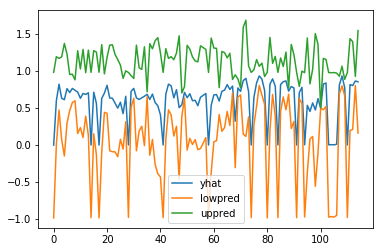

In [94]:
plt.show()

In [ ]:
# plot it!
fig, ax = plt.subplots(1)
ax.plot(t, mu1, lw=2, label='mean population 1', color='blue')
ax.plot(t, mu2, lw=2, label='mean population 2', color='yellow')
ax.fill_between(t, mu1+sigma1, mu1-sigma1, facecolor='blue', alpha=0.5)
ax.fill_between(t, mu2+sigma2, mu2-sigma2, facecolor='yellow', alpha=0.5)
ax.set_title(r'random walkers empirical $\mu$ and $\pm \sigma$ interval')
ax.legend(loc='upper left')
ax.set_xlabel('num steps')
ax.set_ylabel('position')
ax.grid()

In [215]:
yupper = yboot['uppred'].values
ylower = yboot['lowpred'].values

In [216]:
# https://matplotlib.org/gallery/recipes/fill_between_alpha.html
# https://matplotlib.org/users/colors.html
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html
t = np.arange(115)

In [234]:
fig, ax = plt.subplots(1)

In [235]:
ax.plot(yboot['yhat'], 'r-', label='Prediction')
ax.plot(yupper, 'g-')
ax.plot(ylower, 'g-')

In [236]:
ax.fill_between(t, yupper, ylower, facecolor='blue', alpha=0.5, label='95% prediction interval')
#ax.legend(loc='upper left')
ax.legend()
ax.grid()

<Figure size 432x288 with 0 Axes>

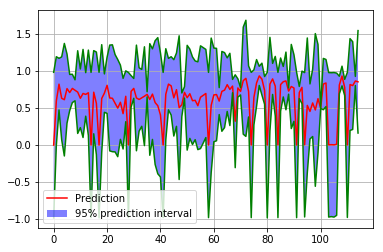

In [237]:
plt.show()

In [238]:
plt.clf()

In [228]:
plt.savefig('./graphs/prediction interval.png', dpi=300)

In [85]:
yboot.to_csv('./csvfiles/ybootstrap_bab5_2.csv')

In [ ]:
# referensi
# a comprehensive review of neural network-based prediction intervals and new advances
# https://stackoverflow.com/questions/41989866/i-created-a-class-to-return-a-confidence-interval-after-bootstrapping-but-my-co
# https://stackoverflow.com/questions/40491298/how-to-calculate-95-confidence-intervals-using-bootstrap-method?noredirect=1&lq=1
# https://stackoverflow.com/questions/20864847/probability-to-z-score-and-vice-versa-in-python